In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [3]:
df_cleaned = pd.read_csv('cleaned_aquair_data.csv')
# Define feature columns and target column
feature_columns = ['temp', 'humid', 'co2', 'voc', 'pm25', 'pm10', 
                   'hour', 'day', 'month', 'year', 'dayofweek']
target_column = 'score'
X = df_cleaned[feature_columns].values
y = df_cleaned[target_column].values

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (23856, 11)
Target shape: (23856,)


In [4]:
def create_sequences(X, y, sequence_length):
    """
    Create sequences for time series forecasting.
    Each sequence contains 'sequence_length' time steps to predict the next value.
    """
    X_sequences = []
    y_sequences = []
    
    for i in range(len(X) - sequence_length):
        X_sequences.append(X[i:i + sequence_length])
        y_sequences.append(y[i + sequence_length])
    
    return np.array(X_sequences), np.array(y_sequences)

# Define sequence length (number of past time steps to use for prediction)
sequence_length = 24  # Use 24 past observations to predict the next one

# Create sequences
X_seq, y_seq = create_sequences(X, y, sequence_length)

print("Sequence features shape:", X_seq.shape)
print("Sequence target shape:", y_seq.shape)



Sequence features shape: (23832, 24, 11)
Sequence target shape: (23832,)


In [5]:
train_size = int(0.6 * len(X_seq))
val_size = int(0.2 * len(X_seq))
# test_size will be the remaining 20%

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val = X_seq[train_size:train_size + val_size]
y_val = y_seq[train_size:train_size + val_size]

X_test = X_seq[train_size + val_size:]
y_test = y_seq[train_size + val_size:]

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X_seq)*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/len(X_seq)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X_seq)*100:.1f}%)")


Training set size: 14299 (60.0%)
Validation set size: 4766 (20.0%)
Test set size: 4767 (20.0%)


In [6]:
# Initialize scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit scalers on training data only
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Transform validation and test data using the same scalers
X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()

X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

In [7]:
class AirQualityDataset(Dataset):
    """Custom Dataset for air quality time series data"""
    
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = AirQualityDataset(X_train_scaled, y_train_scaled)
val_dataset = AirQualityDataset(X_val_scaled, y_val_scaled)
test_dataset = AirQualityDataset(X_test_scaled, y_test_scaled)

# Create data loaders with different batch sizes for experimentation
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Define the model class WITHOUT stochastic depth
class EnhancedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, 
                 dropout_rate=0.3, use_batch_norm=True):
        super(EnhancedLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, 
            batch_first=True, dropout=dropout_rate if num_layers > 1 else 0.0
        )
        
        # Batch normalization for LSTM output
        self.batch_norm_lstm = nn.BatchNorm1d(hidden_size) if use_batch_norm else None
        
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Initialize LSTM forget gate biases
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'bias' in name and 'lstm' in name:
                param.data[self.hidden_size:2*self.hidden_size].fill_(1.0)
    
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        
        # Always use LSTM (no stochastic depth)
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_out = lstm_out[:, -1, :]  # Take last time step
        
        # Apply batch normalization if enabled
        if self.batch_norm_lstm is not None:
            lstm_out = self.batch_norm_lstm(lstm_out)
        
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out)
        return output.squeeze()

# Model parameters WITHOUT stochastic depth
input_size = len(feature_columns)
hidden_size = 64
num_layers = 2
output_size = 1
dropout_rate = 0.1
use_batch_norm = True
# REMOVE: stochastic_depth_rate = 0.1

# Create enhanced model WITHOUT stochastic depth
model = EnhancedLSTMModel(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    dropout_rate=dropout_rate,
    use_batch_norm=use_batch_norm,
    # REMOVE: stochastic_depth_rate=stochastic_depth_rate
)

print("Enhanced LSTM Model architecture (without stochastic depth):")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test forward pass (simpler now)
print("\nTesting forward pass...")
test_batch = torch.randn(4, sequence_length, input_size)
with torch.no_grad():
    test_output = model(test_batch)
    print(f"Input shape: {test_batch.shape}")
    print(f"Output shape: {test_output.shape}")

Enhanced LSTM Model architecture (without stochastic depth):
EnhancedLSTMModel(
  (lstm): LSTM(11, 64, num_layers=2, batch_first=True, dropout=0.1)
  (batch_norm_lstm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Total parameters: 53,185

Testing forward pass...
Input shape: torch.Size([4, 24, 11])
Output shape: torch.Size([4])


In [10]:
# Using Huber loss (smooth L1) which is more robust to outliers
criterion = nn.HuberLoss(delta=1.0)  # Combines benefits of MSE and MAE

# AdamW optimizer with weight decay (L2 regularization)
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.001, 
    weight_decay=0.01,  # L2 regularization
    betas=(0.9, 0.999), 
    eps=1e-8
)

cosine_scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)
plateau_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print("Enhanced Training Setup:")
print(f"Loss function: Huber Loss (delta=1.0)")
print(f"Optimizer: AdamW with learning rate 0.001, weight_decay 0.01")
print(f"Schedulers: CosineAnnealing + ReduceLROnPlateau")
print(f"Dropout rate: {dropout_rate}")
print(f"Batch Normalization: {use_batch_norm}")


Enhanced Training Setup:
Loss function: Huber Loss (delta=1.0)
Optimizer: AdamW with learning rate 0.001, weight_decay 0.01
Schedulers: CosineAnnealing + ReduceLROnPlateau
Dropout rate: 0.1
Batch Normalization: True


In [11]:
class TimeSeriesAugmentation:
    """Data augmentation techniques for time series"""
    
    @staticmethod
    def sequence_dropout(x, dropout_prob=0.1):
        """Randomly drop entire time steps"""
        if not x.requires_grad:  # Not in training mode
            return x
        
        batch_size, seq_len, features = x.shape
        # Create mask for time steps
        mask = torch.bernoulli(torch.ones(seq_len) * (1 - dropout_prob))
        mask = mask.unsqueeze(0).unsqueeze(-1).expand(batch_size, seq_len, features)
        return x * mask.to(x.device)
    
    @staticmethod
    def feature_dropout(x, dropout_prob=0.1):
        """Randomly drop features across all time steps"""
        if not x.requires_grad:
            return x
        
        batch_size, seq_len, features = x.shape
        # Create mask for features
        mask = torch.bernoulli(torch.ones(features) * (1 - dropout_prob))
        mask = mask.unsqueeze(0).unsqueeze(0).expand(batch_size, seq_len, features)
        return x * mask.to(x.device)
    
    @staticmethod
    def jitter(x, sigma=0.01):
        """Add Gaussian noise to the sequence"""
        if not x.requires_grad:
            return x
        return x + torch.randn_like(x) * sigma
    
    @staticmethod
    def scaling(x, sigma=0.1):
        """Random scaling of the sequence"""
        if not x.requires_grad:
            return x
        scaling_factor = torch.randn(x.size(0), 1, 1) * sigma + 1
        return x * scaling_factor.to(x.device)
    
    @staticmethod
    def time_warp(x, sigma=0.2):
        """Time warping augmentation"""
        if not x.requires_grad:
            return x
        
        batch_size, seq_len, features = x.shape
        # Create random warping path
        warp_steps = torch.linspace(0, seq_len-1, seq_len)
        warp_steps = warp_steps + torch.randn(seq_len) * sigma * seq_len
        warp_steps = torch.clamp(warp_steps, 0, seq_len-1)
        
        # Interpolate
        warped_x = torch.zeros_like(x)
        for b in range(batch_size):
            for f in range(features):
                warped_x[b, :, f] = torch.tensor(np.interp(
                    range(seq_len), 
                    warp_steps.numpy(), 
                    x[b, :, f].cpu().numpy()
                ))
        return warped_x.to(x.device)


In [14]:
def train_enhanced_lstm(model, train_loader, val_loader, criterion, optimizer, 
                       cosine_scheduler, plateau_scheduler, num_epochs, 
                       patience=15, grad_clip=1.0, accumulation_steps=1,
                       use_augmentation=True, aug_prob=0.3):
    """
    Train the enhanced LSTM model with comprehensive regularization
    """
    
    train_losses = []
    val_losses = []
    learning_rates = []
    grad_norms = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # Initialize augmentation
    aug = TimeSeriesAugmentation()
    
    for epoch in range(num_epochs):
        model.train()
        train_epoch_loss = 0
        epoch_grad_norm = 0
        batch_count = 0
        
        optimizer.zero_grad()  # Zero gradients at start of epoch
        
        for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
            # Apply data augmentation during training
            if use_augmentation and torch.rand(1).item() < aug_prob:
                # Randomly select augmentation technique
                aug_choice = torch.rand(1).item()
                if aug_choice < 0.25:
                    batch_X = aug.sequence_dropout(batch_X, dropout_prob=0.1)
                elif aug_choice < 0.5:
                    batch_X = aug.feature_dropout(batch_X, dropout_prob=0.1)
                elif aug_choice < 0.75:
                    batch_X = aug.jitter(batch_X, sigma=0.01)
                else:
                    batch_X = aug.scaling(batch_X, sigma=0.05)
            
            # Forward pass with stochastic depth
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Scale loss for gradient accumulation
            loss = loss / accumulation_steps
            
            # Backward pass
            loss.backward()
            
            # Update weights only after accumulating gradients
            if (batch_idx + 1) % accumulation_steps == 0:
                # Gradient clipping
                total_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), 
                    max_norm=grad_clip
                )
                epoch_grad_norm += total_norm.item()
                
                optimizer.step()
                optimizer.zero_grad()
                
                batch_count += 1
            
            train_epoch_loss += loss.item() * accumulation_steps
        
        # Handle remaining gradients if not divisible by accumulation_steps
        if len(train_loader) % accumulation_steps != 0:
            total_norm = torch.nn.utils.clip_grad_norm_(
                model.parameters(), 
                max_norm=grad_clip
            )
            epoch_grad_norm += total_norm.item()
            optimizer.step()
            optimizer.zero_grad()
            batch_count += 1
        
        # Calculate average metrics
        avg_train_loss = train_epoch_loss / len(train_loader)
        avg_grad_norm = epoch_grad_norm / batch_count if batch_count > 0 else 0
        
        train_losses.append(avg_train_loss)
        grad_norms.append(avg_grad_norm)
        
        model.eval()
        val_epoch_loss = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                # No augmentation during validation
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_epoch_loss += loss.item()
        
        avg_val_loss = val_epoch_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Update cosine scheduler
        cosine_scheduler.step()
        
        # Update plateau scheduler based on validation loss
        plateau_scheduler.step(avg_val_loss)
        
        # Track current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            
            # Save checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, 'best_lstm_checkpoint.pth')
            
            print(f'Epoch [{epoch+1:3d}/{num_epochs}] | '
                  f'Train Loss: {avg_train_loss:.4f} | '
                  f'Val Loss: {avg_val_loss:.4f} * | '
                  f'LR: {current_lr:.6f} | '
                  f'Grad Norm: {avg_grad_norm:.2f}')
        else:
            patience_counter += 1
            print(f'Epoch [{epoch+1:3d}/{num_epochs}] | '
                  f'Train Loss: {avg_train_loss:.4f} | '
                  f'Val Loss: {avg_val_loss:.4f} | '
                  f'LR: {current_lr:.6f} | '
                  f'Grad Norm: {avg_grad_norm:.2f}')
        
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered at epoch {epoch+1}')
            break
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'\n--- Progress Summary at Epoch {epoch+1} ---')
            print(f'Best validation loss: {best_val_loss:.4f}')
            print(f'Learning rate: {current_lr:.6f}')
            print(f'Patience counter: {patience_counter}/{patience}')
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nLoaded best model with validation loss: {best_val_loss:.4f}")
    
    return train_losses, val_losses, learning_rates, grad_norms


In [15]:
num_epochs = 100
patience = 15
grad_clip = 1.0
accumulation_steps=2
print("STARTING ENHANCED LSTM TRAINING")
print(f"Epochs: {num_epochs}")
print(f"Patience: {patience}")
print(f"Gradient clipping: {grad_clip}")
print(f"Gradient accumulation steps: {accumulation_steps}")

train_losses, val_losses, learning_rates, grad_norms = train_enhanced_lstm(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    cosine_scheduler=cosine_scheduler,
    plateau_scheduler=plateau_scheduler,
    num_epochs=num_epochs,
    patience=patience,
    grad_clip=grad_clip
)

print(" LSTM TRAINING COMPLETED")

STARTING ENHANCED LSTM TRAINING
Epochs: 100
Patience: 15
Gradient clipping: 1.0
Gradient accumulation steps: 2
Epoch [  1/100] | Train Loss: 0.0382 | Val Loss: 0.0606 * | LR: 0.001000 | Grad Norm: 0.59
Epoch [  2/100] | Train Loss: 0.0268 | Val Loss: 0.0372 * | LR: 0.000999 | Grad Norm: 0.39
Epoch [  3/100] | Train Loss: 0.0229 | Val Loss: 0.0281 * | LR: 0.000998 | Grad Norm: 0.35
Epoch [  4/100] | Train Loss: 0.0212 | Val Loss: 0.0196 * | LR: 0.000996 | Grad Norm: 0.31
Epoch [  5/100] | Train Loss: 0.0212 | Val Loss: 0.0320 | LR: 0.000994 | Grad Norm: 0.32
Epoch [  6/100] | Train Loss: 0.0203 | Val Loss: 0.0311 | LR: 0.000991 | Grad Norm: 0.31
Epoch [  7/100] | Train Loss: 0.0208 | Val Loss: 0.0151 * | LR: 0.000988 | Grad Norm: 0.32
Epoch [  8/100] | Train Loss: 0.0205 | Val Loss: 0.0161 | LR: 0.000984 | Grad Norm: 0.30
Epoch [  9/100] | Train Loss: 0.0196 | Val Loss: 0.0135 * | LR: 0.000980 | Grad Norm: 0.29
Epoch [ 10/100] | Train Loss: 0.0199 | Val Loss: 0.0164 | LR: 0.000976 | Gra

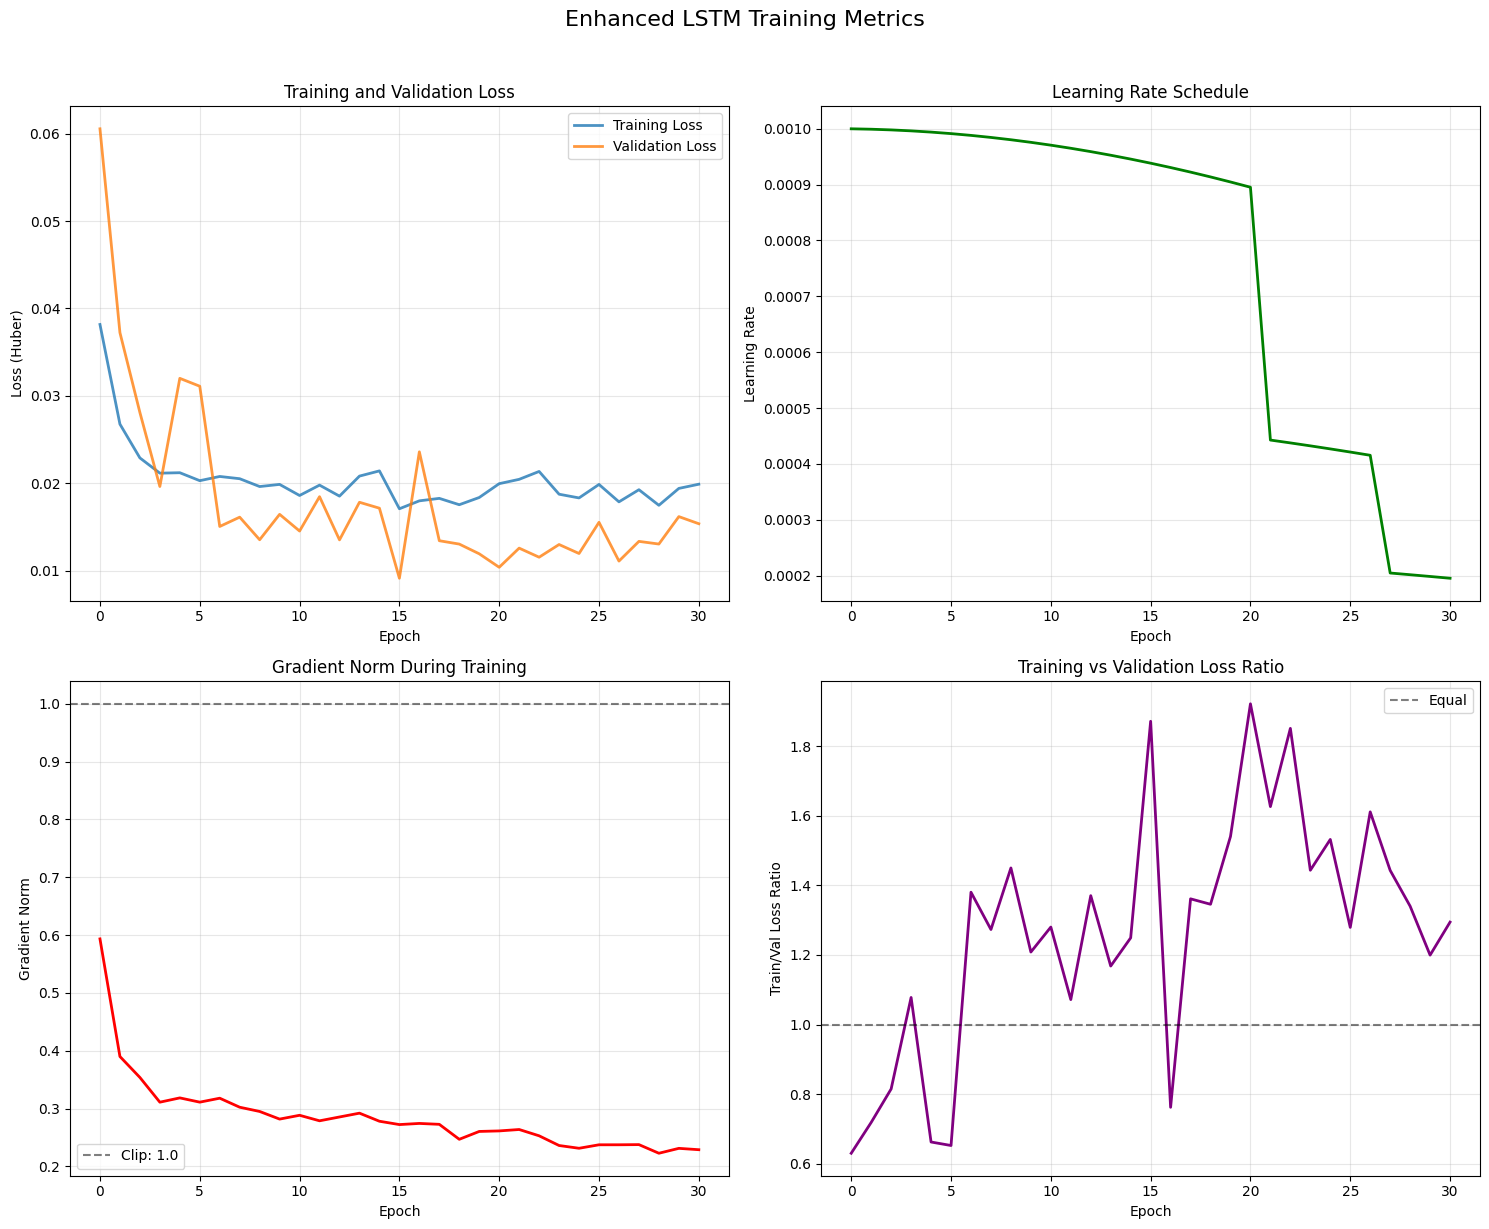

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training and validation loss
axes[0, 0].plot(train_losses, label='Training Loss', linewidth=2, alpha=0.8)
axes[0, 0].plot(val_losses, label='Validation Loss', linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (Huber)')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Learning rate schedule
axes[0, 1].plot(learning_rates, color='green', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Learning Rate')
axes[0, 1].set_title('Learning Rate Schedule')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Gradient norms
axes[1, 0].plot(grad_norms, color='red', linewidth=2)
axes[1, 0].axhline(y=grad_clip, color='black', linestyle='--', alpha=0.5, label=f'Clip: {grad_clip}')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Gradient Norm')
axes[1, 0].set_title('Gradient Norm During Training')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Loss ratio (train/val)
if len(val_losses) > 0 and len(train_losses) > 0:
    loss_ratio = [t/v if v > 0 else 0 for t, v in zip(train_losses, val_losses)]
    axes[1, 1].plot(loss_ratio, color='purple', linewidth=2)
    axes[1, 1].axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Equal')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Train/Val Loss Ratio')
    axes[1, 1].set_title('Training vs Validation Loss Ratio')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Enhanced LSTM Training Metrics', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [17]:
def evaluate_enhanced_model(model, val_loader, scaler_y):
    """Evaluate the enhanced model on validation data"""
    
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            predictions.extend(outputs.numpy())
            actuals.extend(batch_y.numpy())
    
    # Convert to numpy arrays
    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)
    
    # Inverse transform to get original scale
    predictions = scaler_y.inverse_transform(predictions)
    actuals = scaler_y.inverse_transform(actuals)
    
    # Calculate comprehensive metrics
    mse = np.mean((predictions - actuals) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - actuals))
    
    # Calculate R-squared
    ss_res = np.sum((actuals - predictions) ** 2)
    ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((actuals - predictions) / (actuals + 1e-10))) * 100
    
    # Symmetric Mean Absolute Percentage Error
    smape = 100 * np.mean(2 * np.abs(predictions - actuals) / 
                          (np.abs(actuals) + np.abs(predictions) + 1e-10))
    
    print("VALIDATION SET EVALUATION")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Symmetric MAPE (SMAPE): {smape:.2f}%")
    
    return predictions, actuals

# Evaluate on validation set
val_predictions, val_actuals = evaluate_enhanced_model(model, val_loader, scaler_y)

VALIDATION SET EVALUATION
Mean Squared Error (MSE): 26.4668
Root Mean Squared Error (RMSE): 5.1446
Mean Absolute Error (MAE): 3.0651
R-squared (R²): 0.9824
Mean Absolute Percentage Error (MAPE): 114624848.00%
Symmetric MAPE (SMAPE): 53.54%


In [18]:
def evaluate_test_model(model, test_loader, scaler_y):
    """Evaluate the model on test data"""
    
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            predictions.extend(outputs.numpy())
            actuals.extend(batch_y.numpy())
    
    # Convert to numpy arrays
    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)
    
    # Inverse transform to get original scale
    predictions = scaler_y.inverse_transform(predictions)
    actuals = scaler_y.inverse_transform(actuals)
    
    # Calculate metrics
    mse = np.mean((predictions - actuals) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - actuals))
    mape = np.mean(np.abs((actuals - predictions) / (actuals + 1e-10))) * 100
    
    # Calculate R-squared
    ss_res = np.sum((actuals - predictions) ** 2)
    ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    print("TEST SET EVALUATION")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")    
    return predictions, actuals

# Evaluate on test set
test_predictions, test_actuals = evaluate_test_model(model, test_loader, scaler_y)

TEST SET EVALUATION
Mean Squared Error (MSE): 15.1327
Root Mean Squared Error (RMSE): 3.8901
Mean Absolute Error (MAE): 2.6125
R-squared (R²): 0.9004
Mean Absolute Percentage Error (MAPE): 13.26%


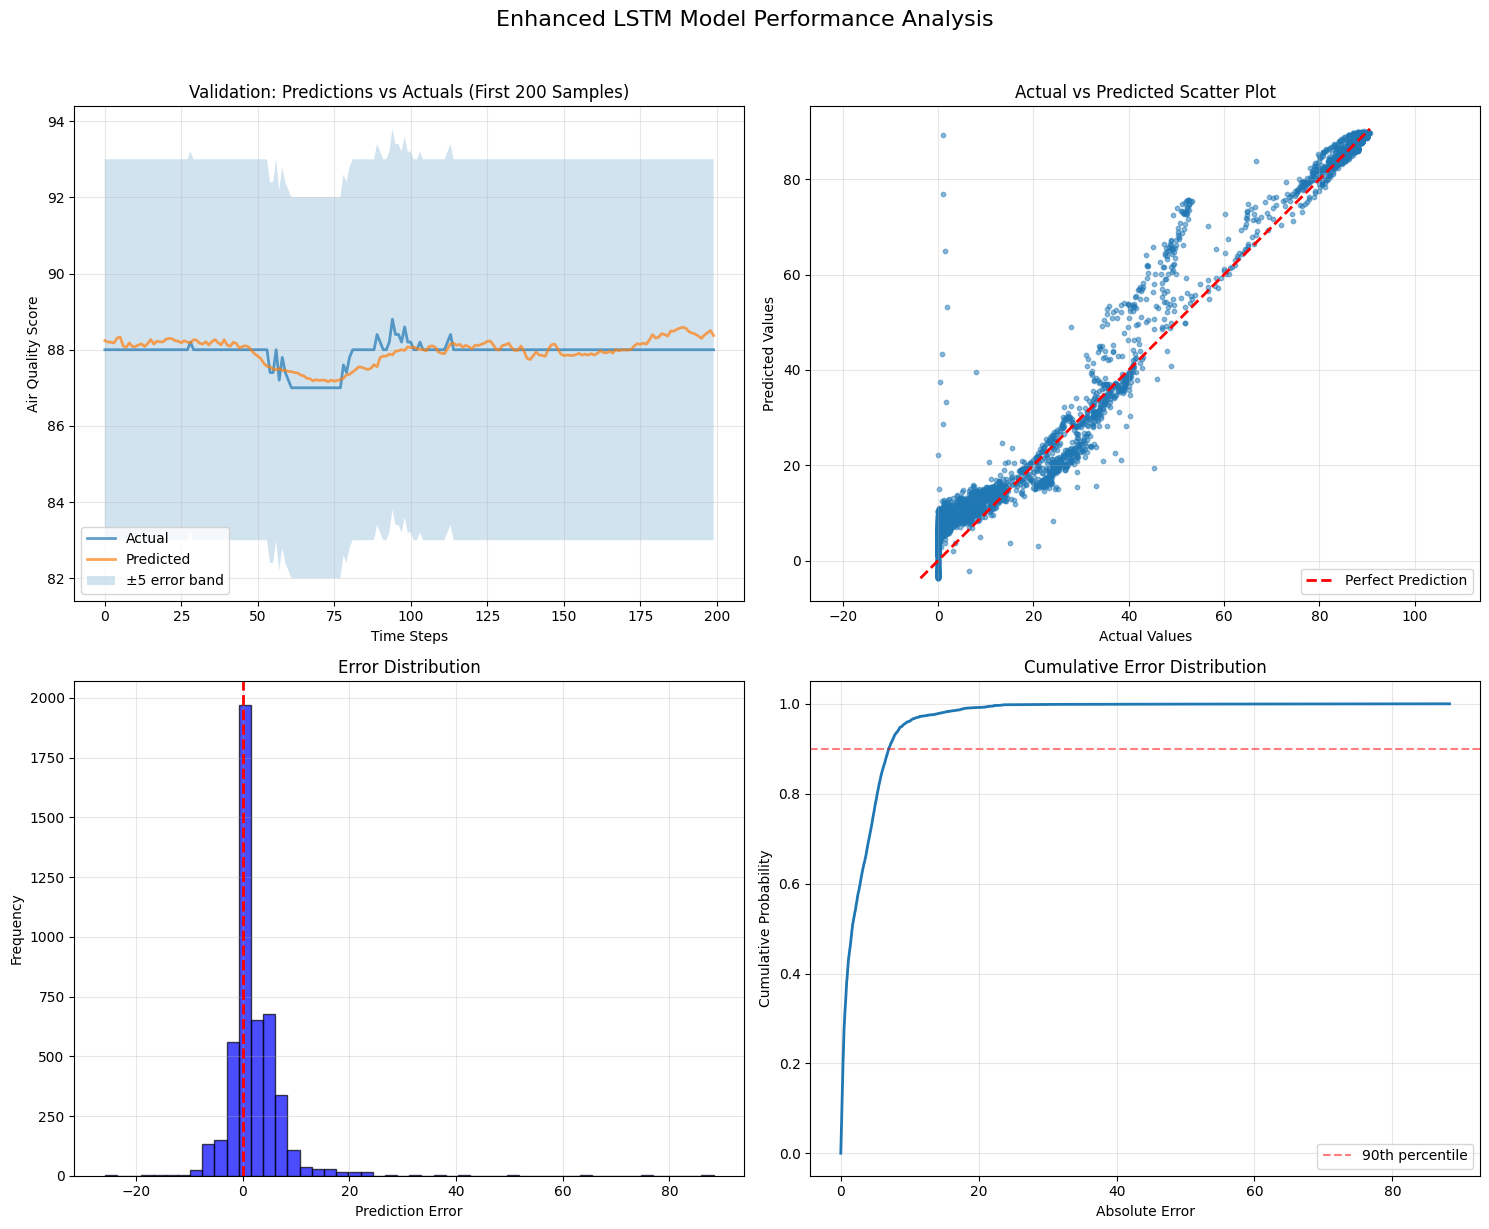

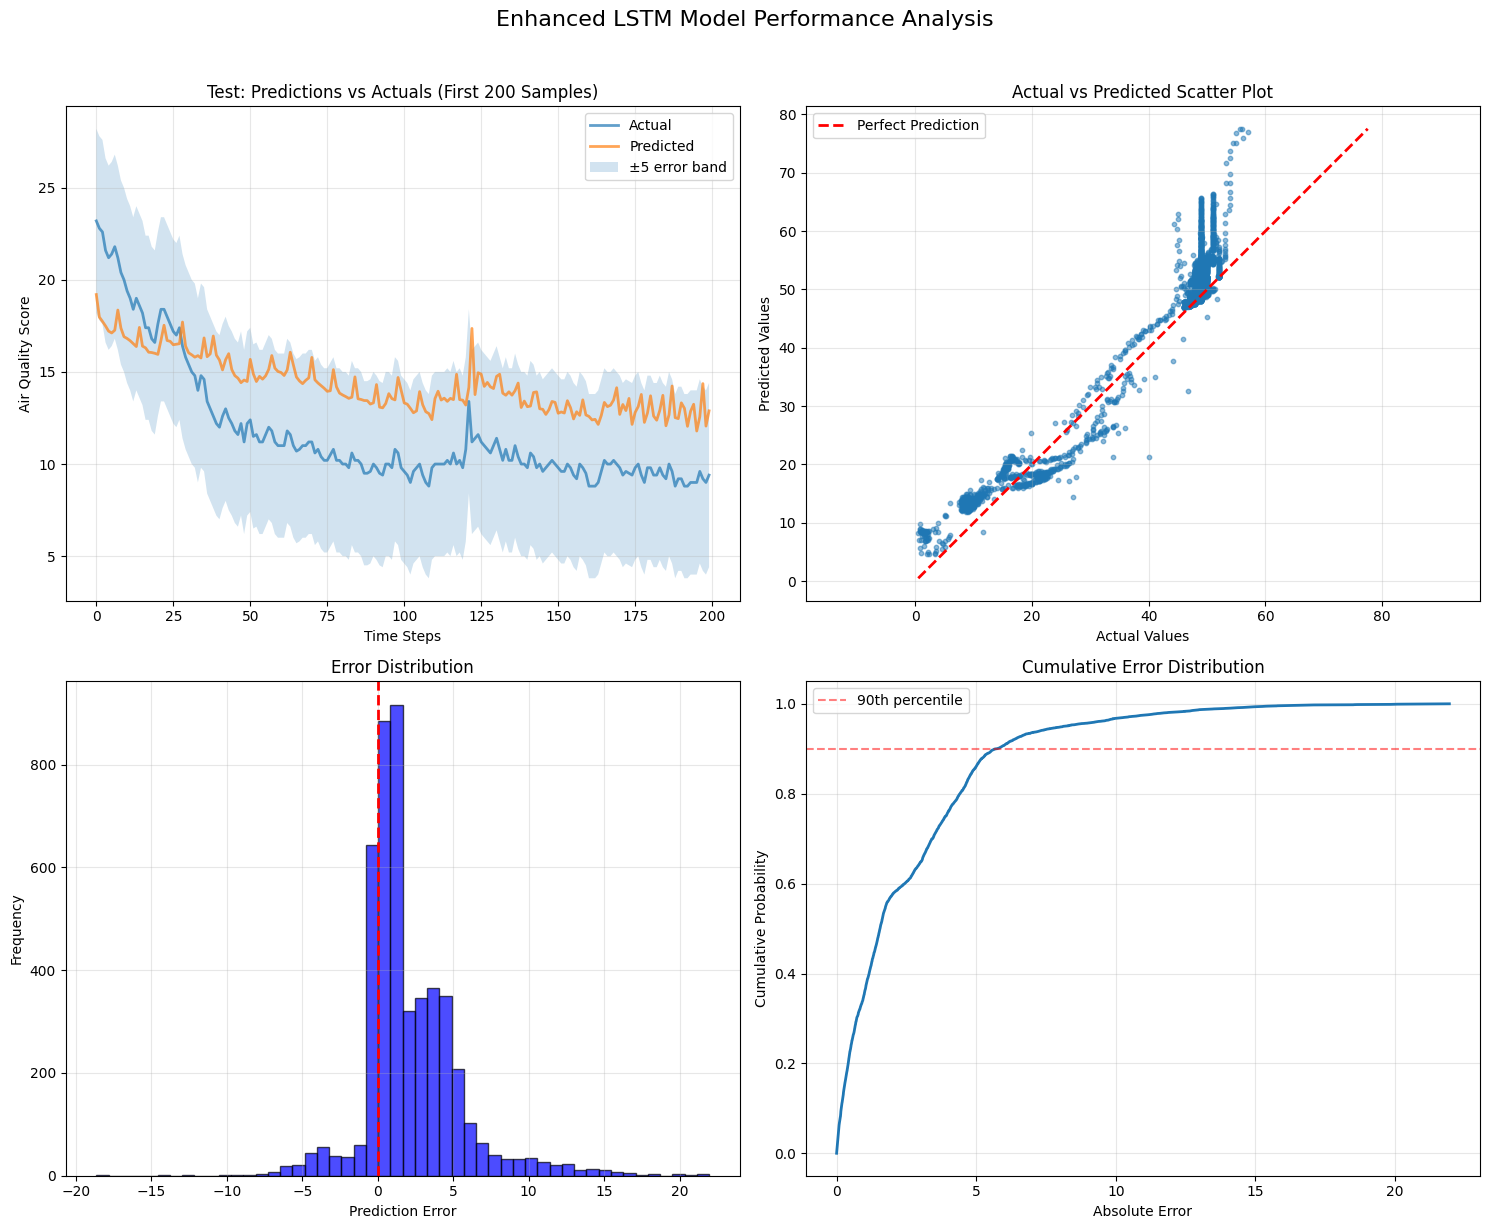

In [19]:
def plot_predictions_comparison(actuals, predictions, title="Predictions vs Actuals"):
    """Create comprehensive prediction visualization"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Time series comparison
    sample_size = min(200, len(actuals))
    axes[0, 0].plot(actuals[:sample_size], label='Actual', alpha=0.7, linewidth=2)
    axes[0, 0].plot(predictions[:sample_size], label='Predicted', alpha=0.7, linewidth=2)
    axes[0, 0].fill_between(range(sample_size), 
                           actuals[:sample_size].flatten() - 5, 
                           actuals[:sample_size].flatten() + 5, 
                           alpha=0.2, label='±5 error band')
    axes[0, 0].set_xlabel('Time Steps')
    axes[0, 0].set_ylabel('Air Quality Score')
    axes[0, 0].set_title(f'{title} (First {sample_size} Samples)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Scatter plot with perfect prediction line
    axes[0, 1].scatter(actuals, predictions, alpha=0.5, s=10)
    # Perfect prediction line
    min_val = min(actuals.min(), predictions.min())
    max_val = max(actuals.max(), predictions.max())
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 
                   'r--', linewidth=2, label='Perfect Prediction')
    axes[0, 1].set_xlabel('Actual Values')
    axes[0, 1].set_ylabel('Predicted Values')
    axes[0, 1].set_title('Actual vs Predicted Scatter Plot')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axis('equal')
    
    # Plot 3: Error distribution
    errors = predictions - actuals
    axes[1, 0].hist(errors, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Prediction Error')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Error Distribution')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Cumulative error
    sorted_errors = np.sort(np.abs(errors.flatten()))
    cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    axes[1, 1].plot(sorted_errors, cumulative, linewidth=2)
    axes[1, 1].axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='90th percentile')
    axes[1, 1].set_xlabel('Absolute Error')
    axes[1, 1].set_ylabel('Cumulative Probability')
    axes[1, 1].set_title('Cumulative Error Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Enhanced LSTM Model Performance Analysis', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Plot validation predictions
plot_predictions_comparison(
    val_actuals, val_predictions, "Validation: Predictions vs Actuals")

# Plot test predictions
plot_predictions_comparison(test_actuals, test_predictions, "Test: Predictions vs Actuals")

In [20]:
def save_enhanced_model(model, scaler_X, scaler_y, feature_columns, sequence_length, 
                       train_losses, val_losses, learning_rates, 
                       batch_size, hidden_size, num_layers, output_size,
                       dropout_rate, use_batch_norm):
    """Save the enhanced model and all training artifacts WITHOUT stochastic depth"""
    
    save_dict = {
        'model_state_dict': model.state_dict(),
        'model_config': {
            'input_size': len(feature_columns),
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'output_size': output_size,
            'dropout_rate': dropout_rate,
            'use_batch_norm': use_batch_norm
            # REMOVE: 'stochastic_depth_rate': stochastic_depth_rate
        },
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'feature_columns': feature_columns,
        'sequence_length': sequence_length,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'learning_rates': learning_rates,
        'training_params': {
            'batch_size': batch_size,
            'learning_rate': 0.001,
            'weight_decay': 0.01,
            'grad_clip': grad_clip,
            'accumulation_steps': accumulation_steps
        }
    }
    
    torch.save(save_dict, 'enhanced_lstm_air_quality_model.pth')
    print("Enhanced LSTM model saved as 'enhanced_lstm_air_quality_model.pth'")
    
    # Also save as ONNX for deployment
    try:
        dummy_input = torch.randn(1, sequence_length, input_size)
        torch.onnx.export(
            model, 
            dummy_input, 
            "enhanced_lstm_model.onnx",
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={'input': {0: 'batch_size'}}
        )
        print("Model also exported as ONNX: 'LSTM_dashboard.onnx'")
    except Exception as e:
        print(f"ONNX export failed: {e}")

# Save the model
save_enhanced_model(
    model=model,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    feature_columns=feature_columns,
    sequence_length=sequence_length,
    train_losses=train_losses,
    val_losses=val_losses,
    learning_rates=learning_rates,
    batch_size=batch_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    dropout_rate=dropout_rate,
    use_batch_norm=use_batch_norm
)

Enhanced LSTM model saved as 'enhanced_lstm_air_quality_model.pth'
ONNX export failed: No module named 'onnxscript'


In [17]:
# ==== SAVE LSTM MODEL FOR STREAMLIT APP ====
import os
import torch

# make sure the folder exists
os.makedirs("models", exist_ok=True)

# build a checkpoint with weights + hyperparameters
lstm_checkpoint = {
    "state_dict": model.state_dict(),  # your trained EnhancedLSTMModel

    # everything needed to rebuild the model in the Streamlit app
    "model_hyperparams": {
        "input_size": input_size,
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "output_size": output_size,
        "dropout_rate": dropout_rate,
        "use_batch_norm": use_batch_norm,
        "stochastic_depth_rate": stochastic_depth_rate,
    },

    # sequence length used when training
    "sequence_length": sequence_length,
}

save_path = "models/lstm_model.pt"
torch.save(lstm_checkpoint, save_path)
print(f"LSTM checkpoint saved to: {save_path}")

LSTM checkpoint saved to: models/lstm_model.pt
